In [1]:
import sys
import os

import pandas as pd
import numpy as np
import scanpy as sc

from sklearn.cluster import KMeans
import scipy.stats
from itertools import combinations
from sklearn.metrics import pairwise_distances

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams.update({'axes.labelsize' : 'large',
                     'pdf.fonttype' : 42
                    }) 
from matplotlib.backends.backend_pdf import PdfPages

from tqdm import tqdm
from tqdm.contrib.concurrent import process_map

import gc
import warnings
import time
import pickle
import json

/project/GCRB/Hon_lab/s223695/anaconda3/envs/scanpy_gpu/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
json_fp = "./config.json"
with open(json_fp, 'r') as fp:
    config = json.load(fp)

In [3]:
figure_folder = os.path.join(config["output_file_name_list"]["OUTPUT_FOLDER"],
                             "image")
if os.path.exists(figure_folder)==False:
    print("generate folder for figure:",figure_folder)
    os.mkdir(figure_folder)
else:
    print("Folder already exist",figure_folder)

Folder already exist /project/GCRB/Hon_lab/s223695/Data_project/Perturb_seq_edist_pipeline/pipeline_output/image


In [4]:
sgRNA_outlier_df = pd.read_csv(os.path.join(config["output_file_name_list"]["OUTPUT_FOLDER"],
                                                  config["output_file_name_list"]["targeting_outlier_table"]),
                                     index_col=0)

nontargeting_outlier_df = pd.read_csv(os.path.join(config["output_file_name_list"]["OUTPUT_FOLDER"],
                                                         config["output_file_name_list"]["non_targeting_outlier_table"]),
                                            index_col=0)

In [5]:
annotation_df = pd.read_csv(os.path.join(config["output_file_name_list"]["OUTPUT_FOLDER"],
                                         config["output_file_name_list"]["annotation_file"]),index_col=0)
annotation_df.head()

,protospacer_ID,target_transcript_name,target_gene_name,source,protospacer,reverse_compliment
0,DNAJC19_ B,DNAJC19,DNAJC19,pos_control,GGGAACTCCTGTAAGGTCAG,CTGACCTTACAGGAGTTCCC
1,POLR1D_ B,POLR1D,POLR1D,pos_control,GGGAAGCAAGGACCGACCGA,TCGGTCGGTCCTTGCTTCCC
2,OR5K2-2,OR5K2,OR5K2,neg_control,GAAAAAATTGTAGAGGAATA,TATTCCTCTACAATTTTTTC
3,SP1_+_53773993.23-P1P2-1,SP1:P1P2,SP1,target,GAAAAACGCGGACGCTGACG,CGTCAGCGTCCGCGTTTTTC
4,SP8_-_20826141.23-P1P2-2,SP8:P1P2,SP8,target,GAAAAAGATCCTCTGAGAGG,CCTCTCAGAGGATCTTTTTC


In [6]:
np.unique(annotation_df["source"])

array(['neg_control', 'non-targeting', 'pos_control', 'target'],
      dtype=object)

#### plot number of <br> (1) gRNAs removed in the outlier analysis and (2) gRNAs remained

In [7]:
target_transcript_name_list = np.unique(annotation_df[annotation_df["source"]!="non-targeting"]["target_transcript_name"])
sgRNA_outlier_dict = sgRNA_outlier_df.to_dict()["pval_outlier"]
gRNA_stat_dict = {}

for target_name in tqdm(target_transcript_name_list):
    gRNA_names_all = annotation_df[annotation_df["target_transcript_name"]==target_name]["protospacer_ID"].values
    gRNA_stat_dict[target_name] = {}
    
    gRNA_dropped = 0
    gRNA_outlier = 0
    gRNA_remained = 0
    
    for gRNA_name in gRNA_names_all:
        if gRNA_name in sgRNA_outlier_dict.keys():
            if sgRNA_outlier_dict[gRNA_name]<0.05:
                gRNA_outlier = gRNA_outlier+1
            else:
                gRNA_remained = gRNA_remained+1
        else:
            gRNA_dropped = gRNA_dropped+1

    gRNA_stat_dict[target_name]["dropped"] = gRNA_dropped
    gRNA_stat_dict[target_name]["outlier"] = gRNA_outlier
    gRNA_stat_dict[target_name]["remained"] = gRNA_remained
    
gRNA_stat_df = pd.DataFrame(gRNA_stat_dict).T

100%|██████████| 2311/2311 [00:01<00:00, 1278.35it/s]


In [8]:
gRNA_stat_df

,dropped,outlier,remained
AARS,3,0,0
AATF:P1P2,6,0,0
ADNP2:P1P2,3,0,3
ADNP:P1P2,6,0,0
AEBP1:P1P2,3,0,3
...,...,...,...
ZUFSP:P1P2,0,0,6
ZXDA:P1P2,0,0,6
ZXDB:P1P2,0,0,6
ZXDC:P1P2,1,0,5


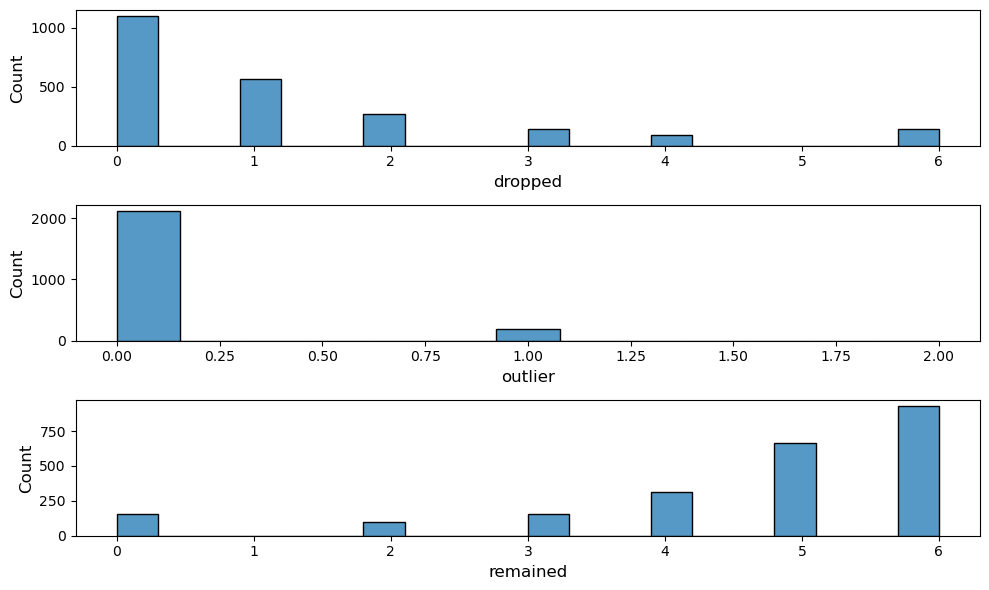

In [9]:
fig,ax = plt.subplots(3,1,figsize=(10,6))
sns.histplot(data=gRNA_stat_df,x="dropped",ax=ax[0])
sns.histplot(data=gRNA_stat_df,x="outlier",ax=ax[1])
sns.histplot(data=gRNA_stat_df,x="remained",ax=ax[2])

plt.tight_layout()
plt.savefig(os.path.join(figure_folder,"gRNA_stat.pdf"))

#### Plot distirbution of energy distance to define cutoff

In [10]:
pval_edit_df = pd.read_csv(os.path.join(config["output_file_name_list"]["OUTPUT_FOLDER"],
                                        config["output_file_name_list"]["edist_pvalue_table"]),
                           index_col=0)

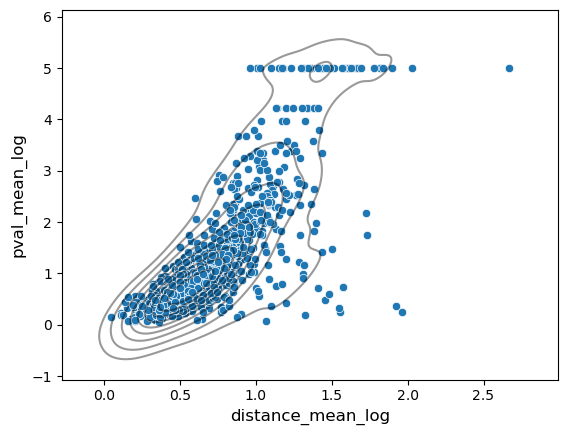

In [19]:
sns.scatterplot(data=pval_edit_df,x="distance_mean_log",y="pval_mean_log")
sns.kdeplot(data=pval_edit_df,x="distance_mean_log",y="pval_mean_log",color="black",alpha=0.4)
plt.savefig(os.path.join(figure_folder,"e-dist_distribution.pdf"))

In [12]:
#### Find best cutoff

In [13]:
max_pval_round = int(np.round(np.max(pval_edit_df["pval_mean_log"])))

pval_list = [1/np.power(10,x) for x in list(range(max_pval_round))]
dist_val_list = [0,5,10,50,100]

In [14]:
pval_list

[1.0, 0.1, 0.01, 0.001, 0.0001]

In [15]:
cutoff_df = pd.DataFrame(index=pval_list,columns=dist_val_list)

for pval_cutoff in pval_list:
    for dist_cutoff in dist_val_list:
        selected_df = pval_edit_df[
                        (pval_edit_df["distance_mean"]>dist_cutoff) &
                        (pval_edit_df["pval_mean"]<pval_cutoff)]
        cutoff_df.loc[pval_cutoff,dist_cutoff] = selected_df.shape[0]

In [20]:
cutoff_df_neg = pd.DataFrame(index=pval_list,columns=dist_val_list)

for pval_cutoff in pval_list:
    for dist_cutoff in dist_val_list:
        selected_df = pval_edit_df[
                        (pval_edit_df["source"]=="neg_control") &
                        (pval_edit_df["distance_mean"]>dist_cutoff) &
                        (pval_edit_df["pval_mean"]<pval_cutoff)]
        cutoff_df_neg.loc[pval_cutoff,dist_cutoff] = selected_df.shape[0]

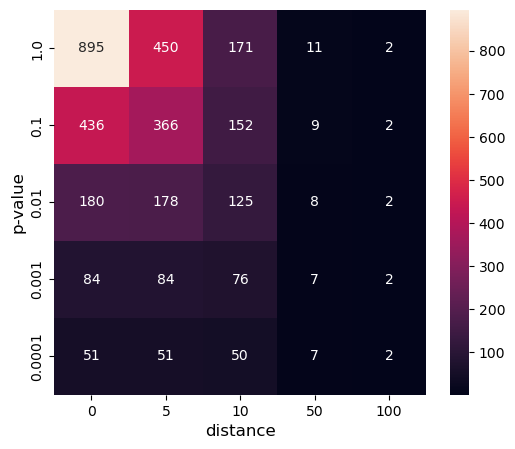

In [16]:
fig,ax = plt.subplots(figsize=(6,5))
sns.heatmap(cutoff_df.astype(float),annot=True,fmt='.0f',ax=ax)
ax.set_xlabel("distance")
ax.set_ylabel("p-value")
plt.savefig(os.path.join(figure_folder,"e-dist_cutoff_value.pdf"))

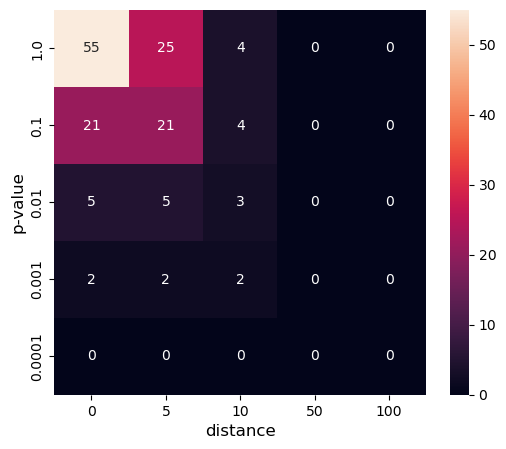

In [24]:
fig,ax = plt.subplots(figsize=(6,5))
sns.heatmap(cutoff_df_neg.astype(float),annot=True,fmt='.0f',ax=ax)
ax.set_xlabel("distance")
ax.set_ylabel("p-value")
plt.savefig(os.path.join(figure_folder,"e-dist_cutoff_value_NEG_CONTROL.pdf"))